# K-Means

In [1]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import psycopg2.extras

root_path = Path().resolve().parent.parent
sys.path.append(str(root_path))

from src.dataset.connection import connect_to_spotify_dataset
from src.dataset.connection import select
from src.utils.distributed_silhouette import DistributedSilhouette

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F

from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import json

from langdetect import detect

In [2]:
connection = connect_to_spotify_dataset(json_file = 'security_details.json') # Add db Password
if not connection:
    print("Connection Error")
tds = select(connection, "SELECT * FROM track_data") 

Connection successful
Connection closed.


In [3]:
columns = [
    "id", "name", "popularity", "duration_ms", "explicit", "artists", "id_artists", "release_date",
    "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", 
    "instrumentalness", "liveness", "valence", "tempo", "time_signature","decade", "mood_index", "emotion_index", "party_index", "chill_index"
]
# Create the DataFrame
df = pd.DataFrame(tds, columns=columns)
print(df.dtypes)
df.head()

id                   object
name                 object
popularity            int64
duration_ms           int64
explicit               bool
artists              object
id_artists           object
release_date         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                   bool
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
decade                int64
mood_index          float64
emotion_index       float64
party_index         float64
chill_index         float64
dtype: object


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index
0,73gfHKufFmtlEBfPhfXrca,Soy Esclavo de Tu Cuerpo,44,195571,False,"[Yampi, Anuel AA]","[3Ia6QnB1tPR9bcgnmbL5FO, 2R21vXR83lH98kGeO99Y66]",2014-02-28,0.705,0.660,...,0.020200,0.0885,0.484,89.980,4,2010,0.5855,1.6198,0.6825,0.40360
1,4DN86kfq76ltzhRt0Zbfh7,Despídete con Un Beso,40,249289,False,[Buddy Richard],[6qSkZrS7Xdje9DVRXlNmpE],2014-01-01,0.520,0.577,...,0.000123,0.1500,0.866,121.070,4,2010,0.7044,3.1847,0.5485,0.36000
2,6Ubz6F0BwkiSk0b1qfXUjl,Creo en Ti,42,240568,False,"[Ana Tijoux, Juanito Ayala]","[40JMTpVRUw90SrN4pFA6Mz, 4Wy8CFlIS11ODC9wVKBSz4]",2014-04-15,0.746,0.578,...,0.000017,0.1450,0.674,91.984,4,2010,0.6764,2.6396,0.6620,0.20474
3,0HqtzBaZpjoEZ84WbbEcoe,Fumo Marihuana,47,213861,True,"[Morodo, Heavy Roots]","[2OnH4HpywAxWkSOEsyjdjn, 4fEogLHgLSsp5ETlJCci09]",2014-10-06,0.797,0.780,...,0.000000,0.2860,0.890,127.946,4,2010,0.8401,1.7414,0.7885,0.37000
4,35TRct8Yqqmy0XUPg8UFbn,Nabundearé,39,175413,False,[Nicole Bunout],[5jyOjqLd2YRArrVlguvv4F],2014,0.433,0.387,...,0.000010,0.1200,0.229,102.648,4,2010,0.3218,3.2686,0.4100,0.65560


# PCA

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

selected_columns = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key',
                    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                    'liveness', 'valence', 'tempo', 'decade',"mood_index","emotion_index","party_index","chill_index"]

X = df[selected_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

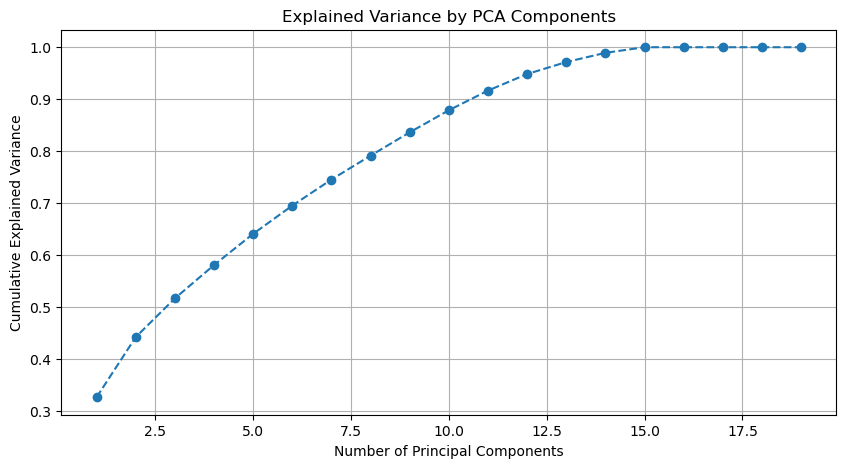

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(selected_columns) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

In [6]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1  # Get number of components for 95% variance

print(f"Number of components needed to explain 95% variance: {n_components}")

pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca_final, columns=[f'PC{i+1}' for i in range(n_components)])

Number of components needed to explain 95% variance: 13


In [7]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,-1.923608,0.216815,1.429029,-0.749358,1.100143,-1.545046,0.862412,0.064454,-0.120919,-0.794141,-0.171781,-1.348370,-0.095211
1,-1.263122,-0.033584,-0.293471,-0.351204,-1.452548,0.606364,0.050187,0.399452,-0.575364,0.026094,0.540956,0.396765,-0.554652
2,-2.239276,-0.116359,1.095530,-0.745712,0.529153,0.235887,0.961824,0.043867,-1.175079,-0.643796,-0.172470,-0.066089,0.007920
3,-3.684049,-0.696342,1.990822,-0.579600,-1.665418,0.639042,-0.602535,-2.670167,1.494730,2.260642,1.103821,0.619691,0.074873
4,1.282279,1.743053,1.140887,-0.860555,0.981311,-2.108115,-0.017262,0.257688,-0.172775,-0.842064,0.330861,-0.109839,0.188596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525582,-3.980816,-0.024021,0.394329,-0.566020,1.235697,-0.054074,1.124274,0.129074,-0.566942,-0.413023,0.035124,-0.124795,0.426075
525583,-3.064142,-0.010076,0.329434,0.132774,-0.256038,-0.231712,1.074822,0.704844,0.694258,-0.159269,-0.385363,-0.970065,-0.612428
525584,-2.045791,-2.076199,-2.672694,0.595499,-0.712938,0.251151,0.123267,-0.778775,0.174060,0.811836,-1.342184,0.549542,-1.375136
525585,-0.770571,0.040217,-0.297150,-1.438698,0.489357,-1.898590,-1.826702,0.095577,-1.189166,0.723768,0.959096,-0.994316,0.090137


In [8]:
# Compute variance of each feature
feature_variance = df[selected_columns].var()

# Sort features by variance (descending order)
feature_variance_sorted = feature_variance.sort_values(ascending=False)

print(feature_variance_sorted)

duration_ms         9.248533e+09
tempo               8.892337e+02
decade              5.233641e+02
popularity          3.352937e+02
loudness            2.599736e+01
key                 1.238093e+01
emotion_index       2.096494e+00
mode                2.252908e-01
acousticness        1.209080e-01
chill_index         8.355716e-02
instrumentalness    7.084767e-02
valence             6.646686e-02
energy              6.337540e-02
explicit            4.300033e-02
speechiness         3.490188e-02
mood_index          3.447737e-02
liveness            3.409099e-02
party_index         2.776405e-02
danceability        2.767026e-02
dtype: float64


# K-Means - SKLearn

In [9]:
df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index
0,73gfHKufFmtlEBfPhfXrca,Soy Esclavo de Tu Cuerpo,44,195571,False,"[Yampi, Anuel AA]","[3Ia6QnB1tPR9bcgnmbL5FO, 2R21vXR83lH98kGeO99Y66]",2014-02-28,0.705,0.660,...,0.020200,0.0885,0.484,89.980,4,2010,0.5855,1.6198,0.6825,0.40360
1,4DN86kfq76ltzhRt0Zbfh7,Despídete con Un Beso,40,249289,False,[Buddy Richard],[6qSkZrS7Xdje9DVRXlNmpE],2014-01-01,0.520,0.577,...,0.000123,0.1500,0.866,121.070,4,2010,0.7044,3.1847,0.5485,0.36000
2,6Ubz6F0BwkiSk0b1qfXUjl,Creo en Ti,42,240568,False,"[Ana Tijoux, Juanito Ayala]","[40JMTpVRUw90SrN4pFA6Mz, 4Wy8CFlIS11ODC9wVKBSz4]",2014-04-15,0.746,0.578,...,0.000017,0.1450,0.674,91.984,4,2010,0.6764,2.6396,0.6620,0.20474
3,0HqtzBaZpjoEZ84WbbEcoe,Fumo Marihuana,47,213861,True,"[Morodo, Heavy Roots]","[2OnH4HpywAxWkSOEsyjdjn, 4fEogLHgLSsp5ETlJCci09]",2014-10-06,0.797,0.780,...,0.000000,0.2860,0.890,127.946,4,2010,0.8401,1.7414,0.7885,0.37000
4,35TRct8Yqqmy0XUPg8UFbn,Nabundearé,39,175413,False,[Nicole Bunout],[5jyOjqLd2YRArrVlguvv4F],2014,0.433,0.387,...,0.000010,0.1200,0.229,102.648,4,2010,0.3218,3.2686,0.4100,0.65560


In [10]:
df.dtypes

id                   object
name                 object
popularity            int64
duration_ms           int64
explicit               bool
artists              object
id_artists           object
release_date         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                   bool
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
decade                int64
mood_index          float64
emotion_index       float64
party_index         float64
chill_index         float64
dtype: object

In [11]:
df_kmeans = df[['duration_ms','danceability','energy','key','loudness','mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'decade']]
df_kmeans.head()

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,decade
0,195571,0.705,0.660,10,-4.094,False,0.2910,0.4460,0.020200,0.0885,0.484,89.980,2010
1,249289,0.520,0.577,1,-8.884,True,0.0465,0.3180,0.000123,0.1500,0.866,121.070,2010
2,240568,0.746,0.578,4,-7.322,False,0.2060,0.0599,0.000017,0.1450,0.674,91.984,2010
3,213861,0.797,0.780,1,-3.838,True,0.0621,0.4700,0.000000,0.2860,0.890,127.946,2010
4,175413,0.433,0.387,11,-10.203,False,0.0309,0.6840,0.000010,0.1200,0.229,102.648,2010


In [12]:
#pre-proc
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_kmeans)

In [13]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)  #sum of squared distances to cluster center

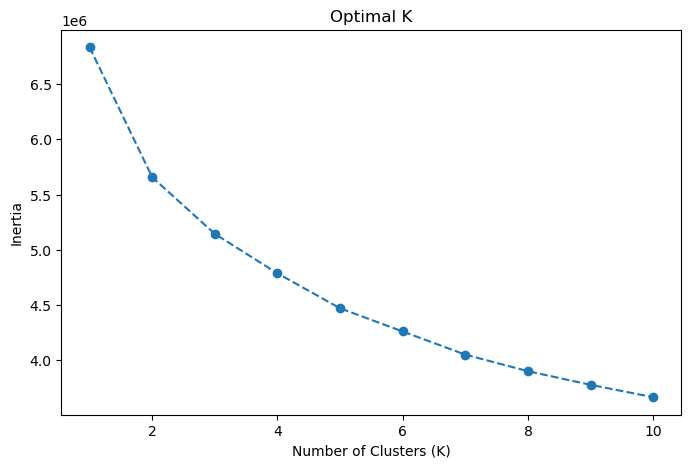

In [14]:
plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Optimal K')
plt.show()

In [15]:
optimal_k = 3 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
#df['Cluster'] = kmeans.fit_predict(df_scaled)

In [16]:
df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index
0,73gfHKufFmtlEBfPhfXrca,Soy Esclavo de Tu Cuerpo,44,195571,False,"[Yampi, Anuel AA]","[3Ia6QnB1tPR9bcgnmbL5FO, 2R21vXR83lH98kGeO99Y66]",2014-02-28,0.705,0.660,...,0.020200,0.0885,0.484,89.980,4,2010,0.5855,1.6198,0.6825,0.40360
1,4DN86kfq76ltzhRt0Zbfh7,Despídete con Un Beso,40,249289,False,[Buddy Richard],[6qSkZrS7Xdje9DVRXlNmpE],2014-01-01,0.520,0.577,...,0.000123,0.1500,0.866,121.070,4,2010,0.7044,3.1847,0.5485,0.36000
2,6Ubz6F0BwkiSk0b1qfXUjl,Creo en Ti,42,240568,False,"[Ana Tijoux, Juanito Ayala]","[40JMTpVRUw90SrN4pFA6Mz, 4Wy8CFlIS11ODC9wVKBSz4]",2014-04-15,0.746,0.578,...,0.000017,0.1450,0.674,91.984,4,2010,0.6764,2.6396,0.6620,0.20474
3,0HqtzBaZpjoEZ84WbbEcoe,Fumo Marihuana,47,213861,True,"[Morodo, Heavy Roots]","[2OnH4HpywAxWkSOEsyjdjn, 4fEogLHgLSsp5ETlJCci09]",2014-10-06,0.797,0.780,...,0.000000,0.2860,0.890,127.946,4,2010,0.8401,1.7414,0.7885,0.37000
4,35TRct8Yqqmy0XUPg8UFbn,Nabundearé,39,175413,False,[Nicole Bunout],[5jyOjqLd2YRArrVlguvv4F],2014,0.433,0.387,...,0.000010,0.1200,0.229,102.648,4,2010,0.3218,3.2686,0.4100,0.65560


# K-Means - PyTorch

In [17]:
# Pre-proc: convert to PyTorch tensor
X = torch.tensor(df_scaled, dtype=torch.float32) 

In [18]:
def compute_inertia(X, k_values):
    """
    Computes inertia (sum of squared distances to the nearest centroid) for different values of k.

    Parameters:
    X (torch.Tensor): The dataset containing feature vectors.
    k_values (list): A list of k values to evaluate.

    Returns:
    list: A list of inertia values corresponding to each k.
    """
    inertia = [] 

    for k in k_values:
        # Randomly initialize k cluster centroids
        num_samples = X.shape[0] 
        random_indices = torch.randperm(num_samples)[:k]  # Randomly select k indices
        centroids = X[random_indices]  # Initial centroids

        # Run K-Means iteratively
        for iteration in range(50):  
            # Pairwise distances between data points and centroids
            distances = torch.cdist(X, centroids)  

            # Assign each data point to the nearest centroid
            labels = torch.argmin(distances, dim=1) 

            # Compute new centroids as the mean of assigned points
            new_centroids = []
            for i in range(k):
                cluster_points = X[labels == i]  
                if cluster_points.shape[0] > 0:
                    new_centroid = cluster_points.mean(dim=0) 
                else:
                    new_centroid = centroids[i]  # Keep old centroid if no points assigned
                new_centroids.append(new_centroid)
            
            # Convert list of tensors into a single tensor
            new_centroids = torch.stack(new_centroids)  

            # Check for convergence 
            centroid_shift = torch.norm(new_centroids - centroids)
            if centroid_shift < 1e-4:
                break  

            # Update centroids for the next iteration
            centroids = new_centroids  

        # Compute inertia 
        min_distances, idx_centroid = torch.min(torch.cdist(X, centroids), dim=1)  
        inertia_value = torch.sum(min_distances ** 2).item()  
        inertia.append(inertia_value) 

    return inertia  

In [19]:
k_values = range(1, 11)
inertia_values = compute_inertia(X, k_values)

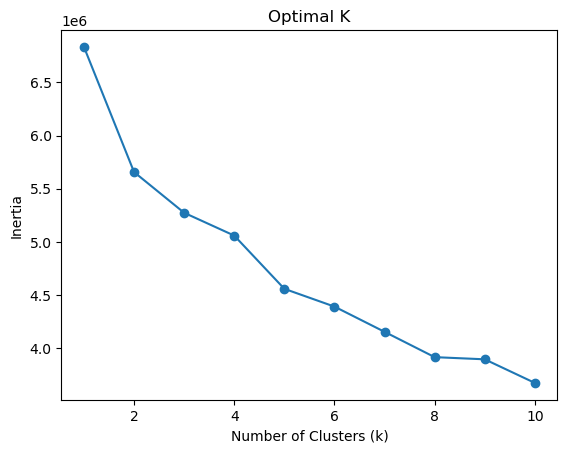

In [20]:
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Optimal K")
plt.show()

In [21]:
def evaluate_clusters(X, k_values):
    """
    Evaluates different k-values using Silhouette Score and Davies Bouldin Index.

    Parameters:
    X (torch.Tensor): Data points.
    k_values (list): List of k values to evaluate.

    Returns:
    dict: Scores for each k.
    """
    scores = {"davies_bouldin": {}}

    for k in k_values:
        # Initialize k-means with k clusters
        num_samples = X.shape[0]
        random_indices = torch.randperm(num_samples)[:k]
        centroids = X[random_indices]

        # Run K-Means clustering
        for j in range(20):  
            distances = torch.cdist(X, centroids)
            labels = torch.argmin(distances, dim=1)

            new_centroids = []
            for i in range(k):
                cluster_points = X[labels == i]
                if cluster_points.shape[0] > 0:
                    new_centroid = cluster_points.mean(dim=0)
                else:
                    new_centroid = centroids[i]
                new_centroids.append(new_centroid)

            new_centroids = torch.stack(new_centroids)
            if torch.norm(new_centroids - centroids) < 1e-4:
                break

            centroids = new_centroids

        # Compute DBI
        labels_np = labels.numpy()
        X_np = X.numpy()

        dbi = davies_bouldin_score(X_np, labels_np) if k > 1 else float("inf")  # Higher k means more separation

        scores["davies_bouldin"][k] = dbi

        print(f"k={k}: Davies-Bouldin Index = {dbi:.4f}")

    return scores


In [22]:
k_values = range(2, 11)  
scores = evaluate_clusters(X, k_values)

k=2: Davies-Bouldin Index = 2.0820
k=3: Davies-Bouldin Index = 2.5450
k=4: Davies-Bouldin Index = 2.3941
k=5: Davies-Bouldin Index = 2.1264
k=6: Davies-Bouldin Index = 2.1769
k=7: Davies-Bouldin Index = 2.0119
k=8: Davies-Bouldin Index = 2.0328
k=9: Davies-Bouldin Index = 1.9892
k=10: Davies-Bouldin Index = 1.9058


In [23]:
k=9
max_iters = 100  
tol = 1e-4 

# Randomly initialize cluster centroids
num_samples = X.shape[0]  
random_indices = torch.randperm(num_samples)[:k]  
centroids = X[random_indices]  

# K-Means 
for iteration in range(max_iters):  
    print(f"Iteration {iteration + 1}") 

    # Compute distances between each data point and centroid
    distances = torch.cdist(X, centroids)  

    # Assign each data point to the nearest centroid
    labels = torch.argmin(distances, dim=1)  

    # Compute new centroids by averaging all points assigned to each cluster
    new_centroids = []  

    for cluster_id in range(k):
        cluster_points = X[labels == cluster_id]  

        if cluster_points.shape[0] > 0:  
            new_centroid = cluster_points.mean(dim=0)
        else:
            new_centroid = centroids[cluster_id]  

        new_centroids.append(new_centroid)  

    new_centroids = torch.stack(new_centroids)  

    # Check for convergence
    centroid_shift = torch.norm(new_centroids - centroids)  
    print(f"Centroid shift: {centroid_shift:.6f}") 

    if centroid_shift < tol:  
        break  

    # Update centroids for the next iteration
    centroids = new_centroids

Iteration 1
Centroid shift: 4.853956
Iteration 2
Centroid shift: 1.865458
Iteration 3
Centroid shift: 1.366179
Iteration 4
Centroid shift: 1.655998
Iteration 5
Centroid shift: 0.919599
Iteration 6
Centroid shift: 0.525998
Iteration 7
Centroid shift: 0.405348
Iteration 8
Centroid shift: 0.339620
Iteration 9
Centroid shift: 0.293155
Iteration 10
Centroid shift: 0.274297
Iteration 11
Centroid shift: 0.215741
Iteration 12
Centroid shift: 0.196039
Iteration 13
Centroid shift: 0.199724
Iteration 14
Centroid shift: 0.219574
Iteration 15
Centroid shift: 0.255746
Iteration 16
Centroid shift: 0.306502
Iteration 17
Centroid shift: 0.327416
Iteration 18
Centroid shift: 0.300306
Iteration 19
Centroid shift: 0.246820
Iteration 20
Centroid shift: 0.160668
Iteration 21
Centroid shift: 0.088429
Iteration 22
Centroid shift: 0.043838
Iteration 23
Centroid shift: 0.023541
Iteration 24
Centroid shift: 0.013987
Iteration 25
Centroid shift: 0.009247
Iteration 26
Centroid shift: 0.005783
Iteration 27
Centroid

In [24]:
clusters = labels.numpy()
clusters[:50]

array([4, 2, 4, 2, 1, 4, 2, 2, 0, 5, 5, 2, 5, 4, 2, 4, 5, 4, 4, 5, 5, 4,
       1, 5, 4, 4, 2, 2, 4, 4, 5, 5, 2, 5, 2, 2, 4, 4, 5, 2, 5, 4, 2, 2,
       4, 4, 4, 4, 4, 5])

In [28]:
labels_dict = {str(i): labels[i].tolist() for i in range(len(labels))}
#labels_dict

In [26]:
with open("kmeans_cluster_labels.json", "w") as f:
    json.dump(labels_dict, f)

In [29]:
# with open("kmeans_cluster_labels.json", "r") as f:
#     cluster_labels = json.load(f)

# labels_array = np.array([cluster_labels[str(i)] for i in range(len(cluster_labels))])

# labels_array[:50]

In [30]:
#silhouette score
distributed_silhouette = DistributedSilhouette(M=10)  # Adjust M as needed
# distributed_silhouette.delete_all_droplets(distributed_silhouette.api_token)

with open("kmeans_cluster_labels.json", "r") as f:
    cluster_labels = json.load(f)

labels_array = np.array([cluster_labels[str(i)] for i in range(len(cluster_labels))])

 # Split dataset into M partitions
partitions, label_partitions = distributed_silhouette.split_data(df_scaled, labels_array)

# Compute silhouette scores in parallel
global_silhouette = distributed_silhouette.compute_fast_silhouette(partitions, label_partitions)
print(f"Silhouette Score: {global_silhouette}")

Setting up the droplet clones...
We are ready to compute the score in parallel!
Calculating...
Done! Cleaning up droplets...
Destroyed droplet: silhouette-clone-0
Destroyed droplet: silhouette-clone-1
Destroyed droplet: silhouette-clone-2
Destroyed droplet: silhouette-clone-3
Destroyed droplet: silhouette-clone-4
Destroyed droplet: silhouette-clone-5
Destroyed droplet: silhouette-clone-6
Destroyed droplet: silhouette-clone-7
Destroyed droplet: silhouette-clone-8
Destroyed droplet: silhouette-clone-9
Droplets destroyed, you are safe to terminate your code!
Silhouette Score: 0.12137065733106196


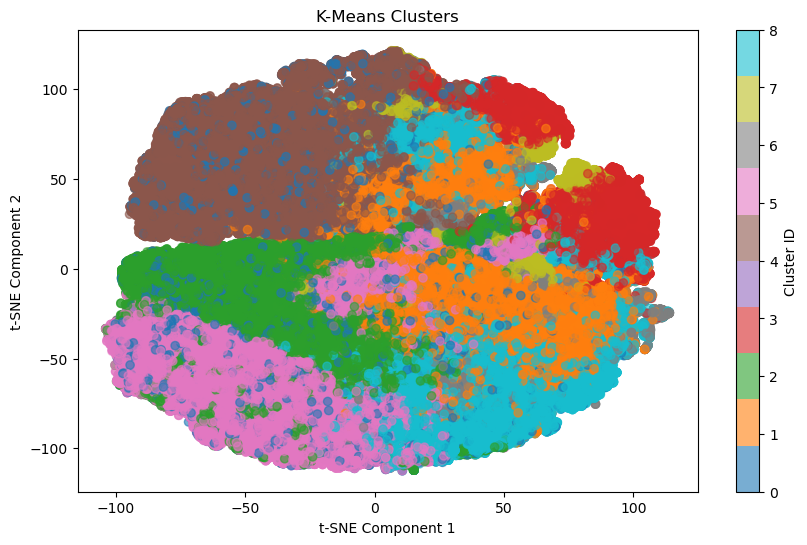

In [57]:
with open("kmeans_cluster_labels.json", "r") as f:
    loaded_labels = json.load(f)

clusters = np.array(list(loaded_labels.values()), dtype=int)

#reduce dimensions to 2D using t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X.numpy())  #convert tensor to NumPy

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap="tab10", alpha=0.6)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("K-Means Clusters")
plt.show()

# K-Means (PCA) - PyTorch

In [31]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,-1.923608,0.216815,1.429029,-0.749358,1.100143,-1.545046,0.862412,0.064454,-0.120919,-0.794141,-0.171781,-1.348370,-0.095211
1,-1.263122,-0.033584,-0.293471,-0.351204,-1.452548,0.606364,0.050187,0.399452,-0.575364,0.026094,0.540956,0.396765,-0.554652
2,-2.239276,-0.116359,1.095530,-0.745712,0.529153,0.235887,0.961824,0.043867,-1.175079,-0.643796,-0.172470,-0.066089,0.007920
3,-3.684049,-0.696342,1.990822,-0.579600,-1.665418,0.639042,-0.602535,-2.670167,1.494730,2.260642,1.103821,0.619691,0.074873
4,1.282279,1.743053,1.140887,-0.860555,0.981311,-2.108115,-0.017262,0.257688,-0.172775,-0.842064,0.330861,-0.109839,0.188596
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525582,-3.980816,-0.024021,0.394329,-0.566020,1.235697,-0.054074,1.124274,0.129074,-0.566942,-0.413023,0.035124,-0.124795,0.426075
525583,-3.064142,-0.010076,0.329434,0.132774,-0.256038,-0.231712,1.074822,0.704844,0.694258,-0.159269,-0.385363,-0.970065,-0.612428
525584,-2.045791,-2.076199,-2.672694,0.595499,-0.712938,0.251151,0.123267,-0.778775,0.174060,0.811836,-1.342184,0.549542,-1.375136
525585,-0.770571,0.040217,-0.297150,-1.438698,0.489357,-1.898590,-1.826702,0.095577,-1.189166,0.723768,0.959096,-0.994316,0.090137


In [32]:
# Pre-proc: convert to PyTorch tensor
X = torch.tensor(df_pca.to_numpy(), dtype=torch.float32) 

In [33]:
k_values = range(1, 11)
inertia_values = compute_inertia(X, k_values)

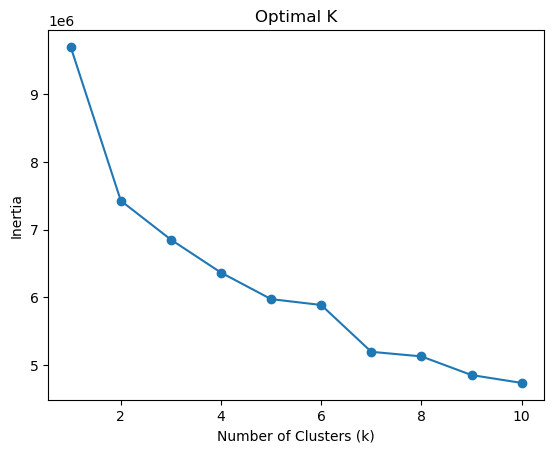

In [34]:
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Optimal K")
plt.show()

In [35]:
k_values = range(2, 11)  
scores = evaluate_clusters(X, k_values)

k=2: Davies-Bouldin Index = 1.7043
k=3: Davies-Bouldin Index = 2.1072
k=4: Davies-Bouldin Index = 1.4530
k=5: Davies-Bouldin Index = 1.8285
k=6: Davies-Bouldin Index = 2.0980
k=7: Davies-Bouldin Index = 2.0309
k=8: Davies-Bouldin Index = 2.2574
k=9: Davies-Bouldin Index = 1.8681
k=10: Davies-Bouldin Index = 1.8372


In [36]:
k = 9
max_iters = 100  
tol = 1e-4 

# Randomly initialize cluster centroids
num_samples = X.shape[0]  
random_indices = torch.randperm(num_samples)[:k]  
centroids = X[random_indices]  

# K-Means 
for iteration in range(max_iters):  
    print(f"Iteration {iteration + 1}") 

    # Compute distances between each data point and centroid
    distances = torch.cdist(X, centroids)  

    # Assign each data point to the nearest centroid
    labels = torch.argmin(distances, dim=1)  

    # Compute new centroids by averaging all points assigned to each cluster
    new_centroids = []  

    for cluster_id in range(k):
        cluster_points = X[labels == cluster_id]  

        if cluster_points.shape[0] > 0:  
            new_centroid = cluster_points.mean(dim=0)
        else:
            new_centroid = centroids[cluster_id]  

        new_centroids.append(new_centroid)  

    new_centroids = torch.stack(new_centroids)  


    # Check for convergence
    centroid_shift = torch.norm(new_centroids - centroids)  
    print(f"Centroid shift: {centroid_shift:.6f}") 

    if centroid_shift < tol:  
        break  

    # Update centroids for the next iteration
    centroids = new_centroids

Iteration 1
Centroid shift: 6.461292
Iteration 2
Centroid shift: 1.637504
Iteration 3
Centroid shift: 0.926344
Iteration 4
Centroid shift: 0.688802
Iteration 5
Centroid shift: 0.792968
Iteration 6
Centroid shift: 1.310297
Iteration 7
Centroid shift: 1.978346
Iteration 8
Centroid shift: 0.391113
Iteration 9
Centroid shift: 0.303035
Iteration 10
Centroid shift: 0.238815
Iteration 11
Centroid shift: 0.197218
Iteration 12
Centroid shift: 0.169608
Iteration 13
Centroid shift: 0.155316
Iteration 14
Centroid shift: 0.144512
Iteration 15
Centroid shift: 0.137985
Iteration 16
Centroid shift: 0.132464
Iteration 17
Centroid shift: 0.128897
Iteration 18
Centroid shift: 0.125214
Iteration 19
Centroid shift: 0.119769
Iteration 20
Centroid shift: 0.108908
Iteration 21
Centroid shift: 0.102580
Iteration 22
Centroid shift: 0.094652
Iteration 23
Centroid shift: 0.087760
Iteration 24
Centroid shift: 0.083000
Iteration 25
Centroid shift: 0.080167
Iteration 26
Centroid shift: 0.076951
Iteration 27
Centroid

In [37]:
clusters_pca = labels.numpy() 
clusters_pca[:50]

array([0, 3, 0, 5, 8, 5, 0, 0, 7, 0, 5, 1, 0, 1, 1, 0, 5, 1, 5, 0, 1, 0,
       8, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 5, 0, 0, 5, 8, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 5, 0])

In [39]:
labels_dict = {str(i): labels[i].tolist() for i in range(len(labels))}
#labels_dict

In [40]:
with open("kmeans_pca_cluster_labels.json", "w") as f:
    json.dump(labels_dict, f)

In [41]:
#silhouette score
distributed_silhouette = DistributedSilhouette(M=10)  # Adjust M as needed

with open("kmeans_pca_cluster_labels.json", "r") as f:
    cluster_labels = json.load(f)

labels_array = np.array([cluster_labels[str(i)] for i in range(len(cluster_labels))])

 # Split dataset into M partitions
partitions, label_partitions = distributed_silhouette.split_data(df_pca, labels_array)

# Compute silhouette scores in parallel
global_silhouette = distributed_silhouette.compute_fast_silhouette(partitions, label_partitions)
print(f"Silhouette Score: {global_silhouette}")

/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Setting up the droplet clones...
We are ready to compute the score in parallel!
Calculating...
Done! Cleaning up droplets...
Destroyed droplet: silhouette-clone-0
Destroyed droplet: silhouette-clone-1
Destroyed droplet: silhouette-clone-2
Destroyed droplet: silhouette-clone-3
Destroyed droplet: silhouette-clone-4
Destroyed droplet: silhouette-clone-5
Destroyed droplet: silhouette-clone-6
Destroyed droplet: silhouette-clone-7
Destroyed droplet: silhouette-clone-8
Destroyed droplet: silhouette-clone-9
Droplets destroyed, you are safe to terminate your code!
Silhouette Score: 0.12547485245945725


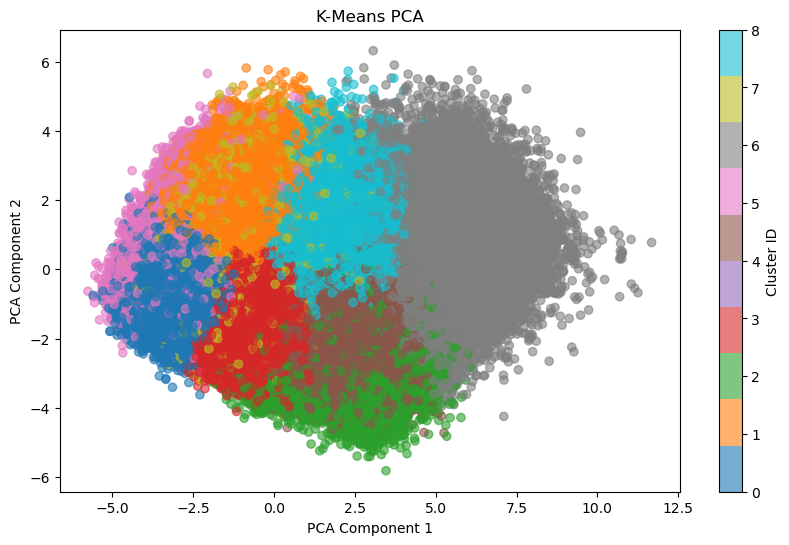

In [42]:
with open("kmeans_pca_cluster_labels.json", "r") as f:
    loaded_labels = json.load(f)

clusters = np.array(list(loaded_labels.values()), dtype=int)

# Reduce dimensions to 2D using PCA for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.numpy())  #convert tensor to numpy for PCA

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap="tab10", alpha=0.6)

plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means PCA")
plt.show()

# K-Means (Feature Variance) - PyTorch

In [43]:
feature_variance_sorted

duration_ms         9.248533e+09
tempo               8.892337e+02
decade              5.233641e+02
popularity          3.352937e+02
loudness            2.599736e+01
key                 1.238093e+01
emotion_index       2.096494e+00
mode                2.252908e-01
acousticness        1.209080e-01
chill_index         8.355716e-02
instrumentalness    7.084767e-02
valence             6.646686e-02
energy              6.337540e-02
explicit            4.300033e-02
speechiness         3.490188e-02
mood_index          3.447737e-02
liveness            3.409099e-02
party_index         2.776405e-02
danceability        2.767026e-02
dtype: float64

In [44]:
df_kmeans = df[['duration_ms','tempo','decade','popularity','loudness','key', 'emotion_index', 'mode', 'acousticness', 'chill_index', 'instrumentalness', 'valence', 'energy']]
df_kmeans.head()

,duration_ms,tempo,decade,popularity,loudness,key,emotion_index,mode,acousticness,chill_index,instrumentalness,valence,energy
0,195571,89.980,2010,44,-4.094,10,1.6198,False,0.4460,0.40360,0.020200,0.484,0.660
1,249289,121.070,2010,40,-8.884,1,3.1847,True,0.3180,0.36000,0.000123,0.866,0.577
2,240568,91.984,2010,42,-7.322,4,2.6396,False,0.0599,0.20474,0.000017,0.674,0.578
3,213861,127.946,2010,47,-3.838,1,1.7414,True,0.4700,0.37000,0.000000,0.890,0.780
4,175413,102.648,2010,39,-10.203,11,3.2686,False,0.6840,0.65560,0.000010,0.229,0.387


In [45]:
#pre-proc
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_kmeans)

In [46]:
# Pre-proc: convert to PyTorch tensor
X = torch.tensor(df_scaled, dtype=torch.float32) 

In [47]:
k_values = range(1, 11)
inertia_values = compute_inertia(X, k_values)

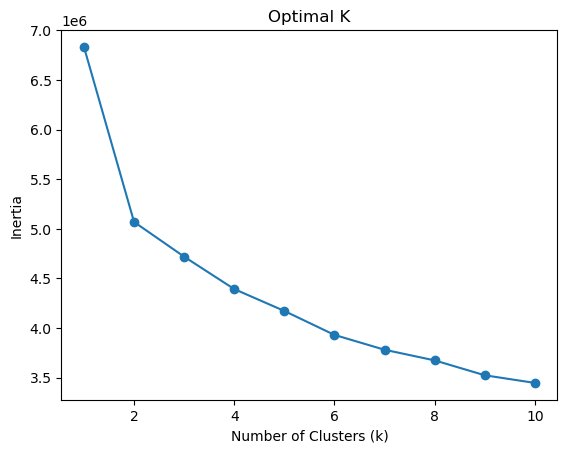

In [48]:
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Optimal K")
plt.show()

In [49]:
k_values = range(2, 11)  
scores = evaluate_clusters(X, k_values)

k=2: Davies-Bouldin Index = 1.6207
k=3: Davies-Bouldin Index = 2.0257
k=4: Davies-Bouldin Index = 2.4727
k=5: Davies-Bouldin Index = 2.4157
k=6: Davies-Bouldin Index = 2.1501
k=7: Davies-Bouldin Index = 2.1249
k=8: Davies-Bouldin Index = 1.9863
k=9: Davies-Bouldin Index = 2.0687
k=10: Davies-Bouldin Index = 2.0635


In [50]:
k = 8
max_iters = 100  
tol = 1e-4 

# Randomly initialize cluster centroids
num_samples = X.shape[0]  
random_indices = torch.randperm(num_samples)[:k]  
centroids = X[random_indices]  

# K-Means 
for iteration in range(max_iters):  
    print(f"Iteration {iteration + 1}") 

    # Compute distances between each data point and centroid
    distances = torch.cdist(X, centroids)  

    # Assign each data point to the nearest centroid
    labels = torch.argmin(distances, dim=1)  

    # Compute new centroids by averaging all points assigned to each cluster
    new_centroids = []  

    for cluster_id in range(k):
        cluster_points = X[labels == cluster_id]  

        if cluster_points.shape[0] > 0:  
            new_centroid = cluster_points.mean(dim=0)
        else:
            new_centroid = centroids[cluster_id]  

        new_centroids.append(new_centroid)  

    new_centroids = torch.stack(new_centroids)  

    # Check for convergence
    centroid_shift = torch.norm(new_centroids - centroids)  
    print(f"Centroid shift: {centroid_shift:.6f}") 

    if centroid_shift < tol:  
        break  

    # Update centroids for the next iteration
    centroids = new_centroids

Iteration 1
Centroid shift: 5.059380
Iteration 2
Centroid shift: 1.044573
Iteration 3
Centroid shift: 0.746554
Iteration 4
Centroid shift: 0.560990
Iteration 5
Centroid shift: 0.430257
Iteration 6
Centroid shift: 0.351254
Iteration 7
Centroid shift: 0.301669
Iteration 8
Centroid shift: 0.269315
Iteration 9
Centroid shift: 0.250030
Iteration 10
Centroid shift: 0.236933
Iteration 11
Centroid shift: 0.234434
Iteration 12
Centroid shift: 0.242459
Iteration 13
Centroid shift: 0.271994
Iteration 14
Centroid shift: 0.274121
Iteration 15
Centroid shift: 0.188241
Iteration 16
Centroid shift: 0.137257
Iteration 17
Centroid shift: 0.113696
Iteration 18
Centroid shift: 0.100658
Iteration 19
Centroid shift: 0.091383
Iteration 20
Centroid shift: 0.084909
Iteration 21
Centroid shift: 0.078771
Iteration 22
Centroid shift: 0.074113
Iteration 23
Centroid shift: 0.071662
Iteration 24
Centroid shift: 0.069900
Iteration 25
Centroid shift: 0.069939
Iteration 26
Centroid shift: 0.070728
Iteration 27
Centroid

In [51]:
clusters_var = labels.numpy()  
clusters_var[:50]

array([4, 0, 4, 0, 5, 4, 0, 0, 4, 0, 0, 0, 0, 4, 0, 4, 0, 4, 4, 0, 2, 4,
       2, 0, 4, 4, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 4, 4, 2, 0, 2, 4, 0, 0,
       4, 4, 4, 4, 4, 0])

In [53]:
labels_dict = {str(i): labels[i].tolist() for i in range(len(labels))}
#labels_dict

In [54]:
with open("kmeans_var_cluster_labels.json", "w") as f:
    json.dump(labels_dict, f)

In [55]:
#silhouette score
distributed_silhouette = DistributedSilhouette(M=10)  # Adjust M as needed

with open("kmeans_var_cluster_labels.json", "r") as f:
    cluster_labels = json.load(f)

labels_array = np.array([cluster_labels[str(i)] for i in range(len(cluster_labels))])

 # Split dataset into M partitions
partitions, label_partitions = distributed_silhouette.split_data(df_scaled, labels_array)

# Compute silhouette scores in parallel
global_silhouette = distributed_silhouette.compute_fast_silhouette(partitions, label_partitions)
print(f"Silhouette Score: {global_silhouette}")

Setting up the droplet clones...
We are ready to compute the score in parallel!
Calculating...
Done! Cleaning up droplets...
Destroyed droplet: silhouette-clone-0
Destroyed droplet: silhouette-clone-1
Destroyed droplet: silhouette-clone-2
Destroyed droplet: silhouette-clone-3
Destroyed droplet: silhouette-clone-4
Destroyed droplet: silhouette-clone-5
Destroyed droplet: silhouette-clone-6
Destroyed droplet: silhouette-clone-7
Destroyed droplet: silhouette-clone-8
Destroyed droplet: silhouette-clone-9
Droplets destroyed, you are safe to terminate your code!
Silhouette Score: 0.12824534249718972


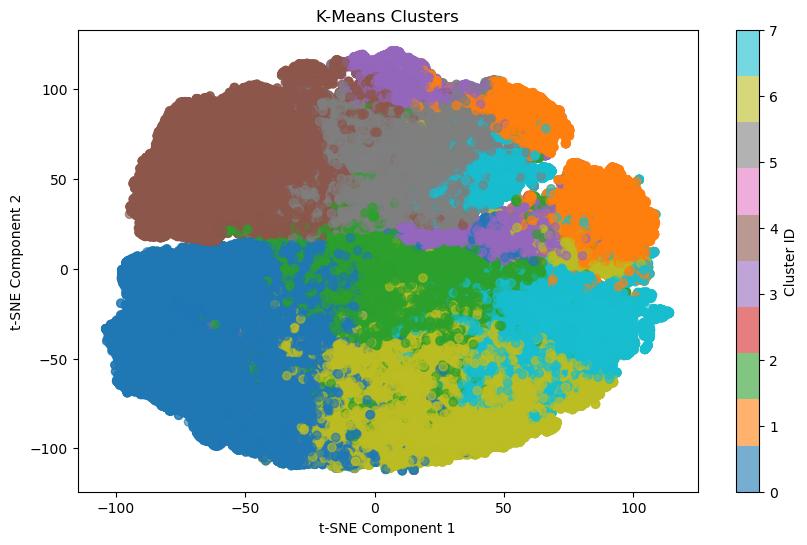

In [56]:
with open("kmeans_var_cluster_labels.json", "r") as f:
    loaded_labels = json.load(f)

clusters = np.array(list(loaded_labels.values()), dtype=int)

#reduce dimensions to 2D using t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X.numpy())  #convert tensor to NumPy

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap="tab10", alpha=0.6)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("K-Means Clusters")
plt.show()

# Playlist Generation

In [32]:
with open("kmeans_var_cluster_labels.json", "r") as f:
    labels_dict = json.load(f)

labels_dict = {int(k): v for k, v in labels_dict.items()}

df["cluster_var"] = pd.Series(labels_dict, dtype=int)

In [33]:
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False  # Handle cases where detection fails

In [34]:
def sample_songs(cluster_df):
    filtered_df = cluster_df[(cluster_df["decade"] == 2020) & (cluster_df["name"].str.contains(r'^[A-Za-z\s]+$', regex=True, na=False))]
    return filtered_df.sample(min(len(filtered_df), 20))  # Sample 20 or all available

In [35]:
playlist_df = df.groupby("cluster_var", group_keys=False).apply(sample_songs).reset_index(drop=True)

/tmp/ipykernel_1162/3748621827.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  playlist_df = df.groupby("cluster_var", group_keys=False).apply(sample_songs).reset_index(drop=True)


In [36]:
playlist_cluster = playlist_df[playlist_df['cluster_var'] == 0]

In [37]:
playlist_cluster

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index,cluster_var
0,3HxgdjvYafgW3CMp57lPmC,The Twelve Days Of Christmas,1,201328,False,[Christmas 2018],[0kfjNNaDWCty5QvomdYqPn],2021-01-01,0.935,0.2230,...,0.0566,0.966,131.016,3,2020,0.8081,4.68990,0.57900,0.7470,0
1,1tkRCqTaPTlnkl170wPHZD,Good Year to Be on Top,0,84785,False,[Jeff Horwich],[1hpgTyXnX02W9DOecmTLsz],2020-05-23,0.608,0.2610,...,0.0813,0.703,142.691,4,2020,0.5861,3.58030,0.43450,0.8578,0
2,518RkZidn283WGPZyIML55,forever alone,41,104211,False,[karmelo diaz],[71gemoocfR9tQk0r12IOM5],2021-01-19,0.836,0.3080,...,0.1100,0.626,113.990,4,2020,0.6254,4.53260,0.57200,0.7298,0
3,0zvFmmDZENvgTZMf66R1U4,Belief in Success,1,247930,False,[Asian Tradition Universe],[2bM5hDOrE0M0MYjAVQotDl],2021-01-04,0.585,0.5760,...,0.3350,0.612,142.136,4,2020,0.5967,4.43970,0.58050,0.5164,0
4,115NjRMQiuUDL8NzFQ19HR,The Twelve Days Of Christmas,1,209528,False,[Christmas 2019],[7KRseUAQnC6c1EP5jziqik],2021-01-01,0.852,0.1290,...,0.0998,0.902,125.920,3,2020,0.7324,6.46490,0.49050,0.9382,0
5,0Ff6xlJONeeTHZN5dK8tvR,minimal,51,150857,False,[eevie],[7razsALHRwNsVCLj4PxiSm],2021-02-13,0.764,0.3670,...,0.1120,0.740,140.020,4,2020,0.6726,4.24490,0.56550,0.7230,0
6,0pfRGNQyWGAkXbXDxW8vwZ,Lemonade,37,121858,False,[Ivo Jebly],[2kvbsF4jvWBOEhEdAUJppb],2021-03-20,0.616,0.2640,...,0.0783,0.972,81.925,4,2020,0.7236,3.56040,0.44000,0.8914,0
7,5fCbY0JD3YLyMVRH6tSlwL,Jug Jug,46,60290,False,[Beatmaker D],[5VlquiWwuFW4FLlLXMZFdr],2020-12-12,0.640,0.2870,...,0.1060,0.705,156.015,4,2020,0.6019,5.18730,0.46350,0.6080,0
8,1Zl6477sVCOCvgweAaB3AG,Flower Garden,50,53404,False,[Dj Blomster],[37jzer6nMrELQIeHZq9q3I],2020-03-22,0.656,0.3890,...,0.1070,0.776,136.118,4,2020,0.6626,4.00850,0.52250,0.6512,0
9,2X22apMQmcOQyM4qGGN94n,This Is Next Year,0,211635,False,[Roger Fly],[612pehWB9CCuUobP9HxW2n],2020-12-09,0.746,0.5130,...,0.1900,0.592,104.947,4,2020,0.6224,4.30270,0.62950,0.3862,0
